In [51]:
import pandas  as pd
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import os
from utils import run_kfold_eval, calculate_metric
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
import joblib
from pathlib import Path
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold

In [112]:
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../output/beta_reg'
OUTPUT_FILE = OUTPUT_PATH + '/beta_regression.pkl'
GENERAL_OUTPUT_FILE = '../output/train_predictions.xlsx'
SHEET_NAME = "beta"

In [3]:
# create path
output_dir = Path(OUTPUT_PATH)
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [5]:
test_features.head()

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,3.125,-122.39680,-0.001341,1.116103,396.408936,399.031738,455.0625,383.612488,341.675812,0.1734,...,False,False,False,False,False,False,False,False,False,False
1,15.000,156.01912,0.000790,6.372588,107.083778,76.414360,118.2482,113.403519,147.756165,0.0253,...,False,False,False,False,False,False,False,False,False,False
2,0.000,-451.10824,-0.002033,43.914617,637.607544,689.770996,683.3611,589.969666,529.166992,0.0406,...,False,False,False,True,False,False,False,False,False,False
3,5.875,-751.22120,-0.000435,74.783398,153.653778,129.425842,158.3252,172.708054,187.147980,1.4908,...,False,False,False,False,False,False,False,False,False,False
4,10.000,55.69036,0.000712,-28.522133,152.290619,148.385330,222.1811,142.140915,159.624313,0.0763,...,False,False,False,False,False,False,False,False,False,False


In [6]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(1293, 317)
(1293, 1)
(432, 317)
(432, 1)


In [7]:
feature_list = train_features.columns
# category_feature_key = ['currency', 'seniorioty_adj', 'domicile_country',	'exchange_country',	'Industry_sector',	'Industry_group',	'Industry_subgroup', 'event_type',
#                  'event_type_subcategory_sum', 'defaulted_in_last_6_months']
# category_features = [i for i in feature_list if any(sub in i for sub in category_feature_key)]
category_features = train_features.select_dtypes(include=['int', 'bool']).columns
non_category_features = [i for i in feature_list if i not in category_features]

print(len(category_features))
print(len(non_category_features))

164
153


In [8]:
category_features

Index(['defaulted_in_last_5_years', 'defaulted_in_last_6_months',
       'currency_CAD', 'currency_CHF', 'currency_CNY', 'currency_EUR',
       'currency_GBP', 'currency_HKD', 'currency_INR', 'currency_ISK',
       ...
       'event_type_subcategory_sum_Missing Coupon payment only',
       'event_type_subcategory_sum_Missing Interest payment',
       'event_type_subcategory_sum_Missing Loan payment',
       'event_type_subcategory_sum_Missing Principal payment',
       'event_type_subcategory_sum_Others',
       'event_type_subcategory_sum_Pre-Negotiated Chapter 11',
       'event_type_subcategory_sum_Protection',
       'event_type_subcategory_sum_Receivership',
       'event_type_subcategory_sum_Rehabilitation',
       'event_type_subcategory_sum_Restructuring'],
      dtype='object', length=164)

In [9]:
# Normalize the data
# Prepare the ColumnTransformer

scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), non_category_features)   # StandardScaler()
    ],
    remainder='passthrough'  # Leave categorical features untouched
)

In [ ]:
def logit(x):
    epsilon = 1e-6
    # x has to be =< 1 and >= 0
    x_cap = max(min(x, 1), 0)
    return np.log((x_cap + epsilon) / (1 - x_cap + epsilon))

In [104]:
def beta_regression(train_features, test_features, train_labels, test_labels):
    # transform features
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)
    
    # tranform logit to train labels for feature selection
    train_labels_logit = train_labels.apply(logit)
    
    # select features
    lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso_cv.fit(train_features_scaled, train_labels_logit)

    print(f"Optimal alpha: {lasso_cv.alpha_}")

    # 3. Get selected features (non-zero coefficients)
    selected_indices = np.where(lasso_cv.coef_ != 0)[0]
    print(f"Number of selected features: {len(selected_indices)}")
    
    # select features
    train_features_selected = train_features_scaled[:, selected_indices]
    test_features_selected = test_features_scaled[:, selected_indices]
    
    # add constant to features
    train_features_with_const = sm.add_constant(train_features_selected)
    test_features_with_const = sm.add_constant(test_features_selected)
    
    # clip y to avoid extreme values
    epsilon = 1e-4 
    train_labels_clipped = train_labels.apply(lambda x: np.clip(a=x,a_max=1-epsilon, a_min=epsilon))
    
    # Fit beta regression model with selected features
    model = sm.GLM(
        train_labels_clipped,
        train_features_with_const,
        family=sm.families.Binomial(link=sm.families.links.Logit())
    )

    results = model.fit()
    print(results.summary())
    
    train_predictions = results.predict(train_features_with_const)
    mae, mape, rmse, rsqr = calculate_metric(train_predictions, train_labels.to_numpy())
    print(f"training results: mae: {mae}, mape: {mape}, rmse: {rmse}, rsqr: {rsqr}")
    
    selected_features = train_features.columns[selected_indices]
    
    # Creating a dataframe of coefficients for easier interpretation
    coef_df = pd.DataFrame({
            'Feature': ['intercept'] + list(selected_features),
            'Coefficient': np.append(results.params[0], results.params[1:]),
            'P-value': np.append(results.pvalues[0], results.pvalues[1:])
        })
    coef_df = coef_df.sort_values('Coefficient', ascending=False)
    predictions = results.predict(test_features_with_const)
    mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels.to_numpy())
     
    return mae, mape, rmse, rsqr, coef_df, results, train_predictions
    

In [105]:
mae, mape, rmse, rsqr, coef_df, model, train_predictions = beta_regression(train_features, test_features, train_labels["rr1_30"], test_labels["rr1_30"])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.510169047303862, tolerance: 2.2170496652843776
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.45583013331816, tolerance: 2.2170496652843776
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.44353126495298, tolerance: 2.2170496652843776
  model = cd_fast.enet_coor

Optimal alpha: 0.09287927950929681
Number of selected features: 32
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rr1_30   No. Observations:                 1293
Model:                            GLM   Df Residuals:                     1260
Model Family:                Binomial   Df Model:                           32
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -618.10
Date:                Mon, 31 Mar 2025   Deviance:                       465.31
Time:                        21:06:08   Pearson chi2:                     435.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1362
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/1059624830.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': np.append(results.params[0], results.params[1:]),
/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/1059624830.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P-value': np.append(results.pvalues[0], results.pvalues[1:])


In [101]:
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")

Val average mean absolute error: 0.23373260353349606
Val average mean absolute percentage error: 381.1609260508918
Val average root mean squared error: 0.2925909121810043
Val average R2: 0.25260644626489814


In [118]:
# save train predictions
train_predictions_df = pd.DataFrame({"predictions": train_predictions})
# train_predictions_df.to_excel(GENERAL_OUTPUT_FILE, sheet_name=SHEET_NAME, index=False)

with pd.ExcelWriter(GENERAL_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    train_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)

In [ ]:
# Save the best model
joblib.dump(model, OUTPUT_FILE)

['../output/beta_reg/beta_regression.pkl']

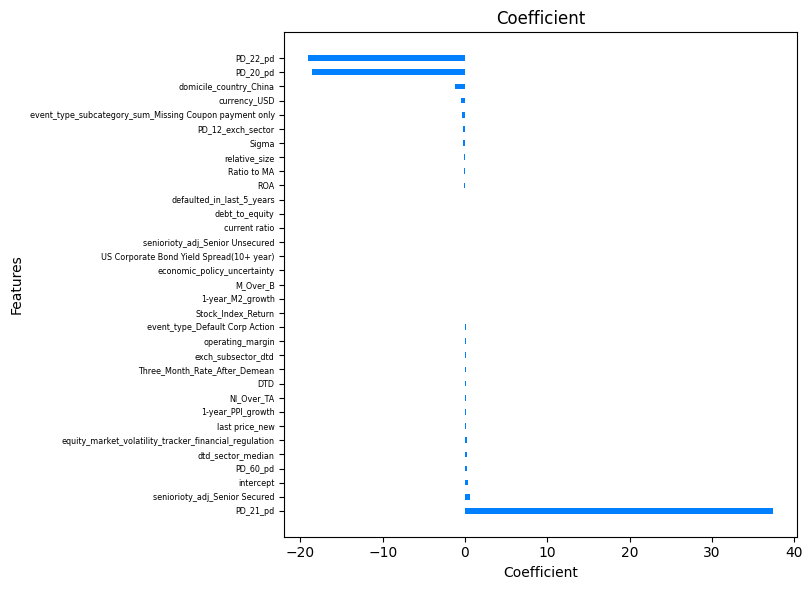

In [86]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=(0, 0.5, 1), height=0.4)  # Adjust the height for spacing
# Increase figure height to accommodate the spacing
# plt.gcf().set_size_inches(10, max(2, len(coef_df) * 0.2))

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Coefficient')  # Label for the x-axis
plt.title('Coefficient')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')
plt.savefig(os.path.join(OUTPUT_PATH,'beta_reg_coefficient.png'))

plt.show()

5-fold CV

In [87]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,False,False,False,False,False,False,False,False,False,False
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,False,True,False,False,False,False,False,False,False,False
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,False,False,False,False,False,False,False,False,False,False
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,False,False,False,False,False,False,False,False,False,False


In [47]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list = []
mape_list = []
rmse_list = []
rsqr_list = []

for fold, (train_idx, test_idx) in enumerate(kf.split(features)):
    print(f"\nFold {fold+1}/5")
    
    # Split data
    X_train, X_test = features.iloc[train_idx, :], features.iloc[test_idx, :]
    y_train, y_test = labels.iloc[train_idx, :], labels.iloc[test_idx, :]
    
    print(X_train.shape)
    
    mae, mape, rmse, rsqr, coef_df, model, predictions = beta_regression(X_train, X_test, y_train["rr1_30"], y_test["rr1_30"])
    mae_list.append(mae)
    mape_list.append(mape)
    rmse_list.append(rmse)
    rsqr_list.append(rsqr)
    
    # Save the best model
    joblib.dump(model, f"{OUTPUT_PATH}/regression_fold_{fold}.pkl")
    


Fold 1/5
(1380, 317)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8930418644213205, tolerance: 2.4842538049859595
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.076131813162647, tolerance: 2.4842538049859595
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.622322010462085, tolerance: 2.4842538049859595
  model = cd_fast.enet_co

Optimal alpha: 0.10003621443350087
Number of selected features: 31
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rr1_30   No. Observations:                 1380
Model:                            GLM   Df Residuals:                     1348
Model Family:                Binomial   Df Model:                           31
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -665.81
Date:                Mon, 31 Mar 2025   Deviance:                       519.25
Time:                        20:06:35   Pearson chi2:                     485.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1318
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': np.append(results.params[0], results.params[1:]),
/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P-value': np.append(results.pvalues[0], results.pvalues[1:])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Optimal alpha: 0.07851043814879562
Number of selected features: 42
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rr1_30   No. Observations:                 1380
Model:                            GLM   Df Residuals:                     1338
Model Family:                Binomial   Df Model:                           41
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -648.42
Date:                Mon, 31 Mar 2025   Deviance:                       484.99
Time:                        20:08:26   Pearson chi2:                     455.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1541
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': np.append(results.params[0], results.params[1:]),
/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P-value': np.append(results.pvalues[0], results.pvalues[1:])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Optimal alpha: 0.009433596645111963
Number of selected features: 115
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rr1_30   No. Observations:                 1380
Model:                            GLM   Df Residuals:                     1271
Model Family:                Binomial   Df Model:                          108
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -604.35
Date:                Mon, 31 Mar 2025   Deviance:                       389.66
Time:                        20:22:03   Pearson chi2:                     367.
No. Iterations:                    99   Pseudo R-squ. (CS):             0.2041
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': np.append(results.params[0], results.params[1:]),
/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P-value': np.append(results.pvalues[0], results.pvalues[1:])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Optimal alpha: 0.013497438563643348
Number of selected features: 110
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rr1_30   No. Observations:                 1380
Model:                            GLM   Df Residuals:                     1276
Model Family:                Binomial   Df Model:                          103
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -612.54
Date:                Mon, 31 Mar 2025   Deviance:                       418.71
Time:                        20:33:25   Pearson chi2:                     391.
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1990
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': np.append(results.params[0], results.params[1:]),
/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P-value': np.append(results.pvalues[0], results.pvalues[1:])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Optimal alpha: 0.07315164026303572
Number of selected features: 38
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rr1_30   No. Observations:                 1380
Model:                            GLM   Df Residuals:                     1342
Model Family:                Binomial   Df Model:                           37
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -658.72
Date:                Mon, 31 Mar 2025   Deviance:                       486.48
Time:                        20:35:19   Pearson chi2:                     438.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1343
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': np.append(results.params[0], results.params[1:]),
/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_35179/3180286792.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P-value': np.append(results.pvalues[0], results.pvalues[1:])


In [89]:
print(f"Test average mean absolute error: {np.mean(mae_list)}")
print(f"Test average mean absolute percentage error: {np.mean(mape_list)}")
print(f"Test average root mean squared error: {np.mean(rmse_list)}")
print(f"Test average R2: {np.mean(rsqr_list)}")

Test average mean absolute error: 0.21724798510103138
Test average mean absolute percentage error: 3651.1821144073665
Test average root mean squared error: 0.2752895054169664
Test average R2: 0.3090842884005391


In [90]:
rmse_list

[0.2662902752457009,
 0.27833885625061416,
 0.2901275482433718,
 0.2516011393872319,
 0.29008970795791317]

In [79]:
rsqr_list

[0.3404862714843173,
 0.2668958209659995,
 -1.7424282254511176,
 0.3695065786702453,
 0.3197913516775338]